# Parameter Management

Once we have chosen an architecture
and set our hyperparameters,
we proceed to the training loop,
where our goal is to find parameter values
that minimize our loss function.
After training, we will need these parameters
in order to make future predictions.
Additionally, we will sometimes wish
to extract the parameters
perhaps to reuse them in some other context,
to save our model to disk so that
it may be executed in other software,
or for examination in the hope of
gaining scientific understanding.

Most of the time, we will be able
to ignore the nitty-gritty details
of how parameters are declared
and manipulated, relying on deep learning frameworks
to do the heavy lifting.
However, when we move away from
stacked architectures with standard layers,
we will sometimes need to get into the weeds
of declaring and manipulating parameters.
In this section, we cover the following:

* Accessing parameters for debugging, diagnostics, and visualizations.
* Sharing parameters across different model components.


In [1]:
!pip install d2l==1.0.3


In [12]:
import torch
from torch import nn
from torch.nn import functional as F

(**We start by focusing on an MLP with one hidden layer.**)


In [4]:
net = nn.Sequential(nn.LazyLinear(8),
                    nn.ReLU(),
                    nn.LazyLinear(1))

X = torch.rand(size=(2, 4))
net(X).shape

torch.Size([2, 1])

## [**Parameter Access**]
:label:`subsec_param-access`

Let's start with how to access parameters
from the models that you already know.


When a model is defined via the `Sequential` class,
we can first access any layer by indexing
into the model as though it were a list.
Each layer's parameters are conveniently
located in its attribute.


We can inspect the parameters of the second fully connected layer as follows.


In [5]:
net[2].state_dict()

OrderedDict([('weight',
              tensor([[ 0.2915, -0.1141,  0.3016, -0.2343, -0.3530, -0.1606,  0.0471, -0.2914]])),
             ('bias', tensor([0.3169]))])

We can see that this fully connected layer
contains two parameters,
corresponding to that layer's
weights and biases, respectively.


### [**Targeted Parameters**]

Note that each parameter is represented
as an instance of the parameter class.
To do anything useful with the parameters,
we first need to access the underlying numerical values.
There are several ways to do this.
Some are simpler while others are more general.
The following code extracts the bias
from the second neural network layer, which returns a parameter class instance, and
further accesses that parameter's value.


In [6]:
type(net[2].bias), net[2].bias.data

(torch.nn.parameter.Parameter, tensor([0.3169]))

Parameters are complex objects,
containing values, gradients,
and additional information.
That is why we need to request the value explicitly.

In addition to the value, each parameter also allows us to access the gradient. Because we have not invoked backpropagation for this network yet, it is in its initial state.


In [7]:
net[2].weight.grad == None

True

### [**All Parameters at Once**]

When we need to perform operations on all parameters,
accessing them one-by-one can grow tedious.
The situation can grow especially unwieldy
when we work with more complex, e.g., nested, modules,
since we would need to recurse
through the entire tree to extract
each sub-module's parameters. Below we demonstrate accessing the parameters of all layers.


In [8]:
[(name, param.shape) for name, param in net.named_parameters()]

[('0.weight', torch.Size([8, 4])),
 ('0.bias', torch.Size([8])),
 ('2.weight', torch.Size([1, 8])),
 ('2.bias', torch.Size([1]))]

## [**Tied Parameters**]

Often, we want to share parameters across multiple layers.
Let's see how to do this elegantly.
In the following we allocate a fully connected layer
and then use its parameters specifically
to set those of another layer.
Here we need to run the forward propagation
`net(X)` before accessing the parameters.


In [9]:
# We need to give the shared layer a name so that we can refer to its
# parameters
shared = nn.LazyLinear(8)
net = nn.Sequential(nn.LazyLinear(8), nn.ReLU(),
                    shared, nn.ReLU(),
                    shared, nn.ReLU(),
                    nn.LazyLinear(1))

net(X)
# Check whether the parameters are the same
print(net[2].weight.data[0] == net[4].weight.data[0])
net[2].weight.data[0, 0] = 100
# Make sure that they are actually the same object rather than just having the
# same value
print(net[2].weight.data[0] == net[4].weight.data[0])

tensor([True, True, True, True, True, True, True, True])
tensor([True, True, True, True, True, True, True, True])


This example shows that the parameters
of the second and third layer are tied.
They are not just equal, they are
represented by the same exact tensor.
Thus, if we change one of the parameters,
the other one changes, too.


You might wonder,
when parameters are tied
what happens to the gradients?
Since the model parameters contain gradients,
the gradients of the second hidden layer
and the third hidden layer are added together
during backpropagation.


## Summary

We have several ways of accessing and tying model parameters.


## Exercises

1. Use the `NestMLP` model defined in :numref:`sec_model_construction` and access the parameters of the various layers.
1. Construct an MLP containing a shared parameter layer and train it. During the training process, observe the model parameters and gradients of each layer.
1. Why is sharing parameters a good idea?


[Discussions](https://discuss.d2l.ai/t/57)


### Exercise 1:

In [10]:
class FixedHiddenMLP(nn.Module):
    def __init__(self):
        super().__init__()
        # Random weight parameters that will not compute gradients and
        # therefore keep constant during training
        self.rand_weight = torch.rand((20, 20))
        self.linear = nn.LazyLinear(20)

    def forward(self, X):
        X = self.linear(X)
        X = F.relu(X @ self.rand_weight + 1)
        # Reuse the fully connected layer. This is equivalent to sharing
        # parameters with two fully connected layers
        X = self.linear(X)
        # Control flow
        while X.abs().sum() > 1:
            X /= 2
        return X.sum()


In [13]:
class NestMLP(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(nn.LazyLinear(64), nn.ReLU(),
                                 nn.LazyLinear(32), nn.ReLU())
        self.linear = nn.LazyLinear(16)

    def forward(self, X):
        return self.linear(self.net(X))

chimera = nn.Sequential(NestMLP(), nn.LazyLinear(20), FixedHiddenMLP())
chimera(X)


tensor(-0.2616, grad_fn=<SumBackward0>)

In [18]:
chimera[0].net

Sequential(
  (0): Linear(in_features=4, out_features=64, bias=True)
  (1): ReLU()
  (2): Linear(in_features=64, out_features=32, bias=True)
  (3): ReLU()
)

In [20]:
chimera[0].net[0].state_dict()

OrderedDict([('weight',
              tensor([[-0.3017, -0.1691, -0.1873, -0.4200],
                      [ 0.4201, -0.0540, -0.2727,  0.4964],
                      [ 0.3684,  0.0975,  0.3976,  0.4503],
                      [ 0.0781, -0.0686,  0.3504,  0.2363],
                      [-0.4857,  0.1826,  0.0657,  0.4199],
                      [-0.0649, -0.4723, -0.1363, -0.4148],
                      [-0.4141,  0.4133, -0.3165,  0.3070],
                      [ 0.3938, -0.2942,  0.0932, -0.0682],
                      [-0.2176,  0.3815, -0.3748,  0.0024],
                      [-0.1658, -0.1300, -0.1921,  0.0932],
                      [-0.4418,  0.0038, -0.1048, -0.0431],
                      [-0.0861,  0.1871,  0.1708, -0.2568],
                      [-0.2831,  0.3364, -0.2462, -0.0678],
                      [ 0.3829,  0.1103,  0.4383,  0.0478],
                      [ 0.2939, -0.4721,  0.0323,  0.3583],
                      [ 0.3151,  0.4980,  0.2380,  0.2826],
                

### Exercise 2:

In [ ]:
class SharedMLP(nn.Module):
    def __init__(self):
        super().__init__()
        shared = nn.LazyLinear(32)
        self.net = nn.Sequential(nn.LazyLinear(8), nn.ReLU(),
                                    shared, nn.ReLU(),
                                    nn.LazyLinear(8))

    def forward(self, X):
        return self.net(X)

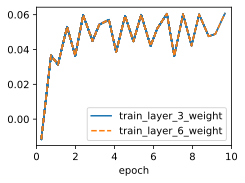

In [3]:
import torch.nn as nn
import torch
import warnings
from d2l import torch as d2l

class PlotParameterMLP(d2l.Classifier):
    def __init__(self, num_outputs, num_hiddens, lr, dropouts):
        super().__init__()
        self.save_hyperparameters()
        layers = [nn.Flatten(),nn.LazyLinear(num_hiddens[0]),nn.ReLU()]
        shared = nn.LazyLinear(num_hiddens[1])
        self.activations = []
        for i in range(1,len(num_hiddens)):
            layers.append(shared)
            layers.append(nn.ReLU())
            layers.append(nn.Dropout(dropouts[i]))
            self.activations.append(i*3)
        layers.append(nn.LazyLinear(num_outputs))
        self.net = nn.Sequential(*layers)

    def training_step(self, batch, plot_flag=True):
        y_hat = self(*batch[:-1])
        # auc = torch.tensor(roc_auc_score(batch[-1].detach().numpy() , y_hat[:,1].detach().numpy()))
        if plot_flag:
            for i in self.activations:
                # print(self.net[i].weight.data,self.net[i].weight.grad)
                self.plot(f'layer_{i}_weight',self.net[i].weight.data.mean(),train=True)
                # self.plot(f'layer_{i}_weight',self.net[i].weight.grad.mean(),train=True)
        return self.loss(y_hat, batch[-1])

    def validation_step(self, batch, plot_flag=True):
        y_hat = self(*batch[:-1])
        # auc = torch.tensor(roc_auc_score(batch[-1].detach().numpy() , y_hat[:,1].detach().numpy()))
        if plot_flag:
            for i in self.activations:
                # self.plot(f'layer_{i}_weight',self.net[i].weight.data.mean(),train=True)
                self.plot(f'layer_{i}_weight',self.net[i].weight.grad.mean(),train=True)
        return self.loss(y_hat, batch[-1])

    def stat_activation_variance(self, i, X):
        activation = self.net[:i](X)
        return ((activation-activation.mean(axis=0,keepdim=True))**2).mean()

data = d2l.FashionMNIST(batch_size=256)
hparams = {'num_outputs':10,'num_hiddens':[8]*3,
           'dropouts':[0]*3,'lr':0.1}
model = PlotParameterMLP(**hparams)
trainer = d2l.Trainer(max_epochs=10)
trainer.fit(model, data)